In [1]:
!pip install -U sentence-transformers
!pip install bertopic
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompat

# Clustering word embeddings

In [ ]:
import re
from collections import Counter

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [3]:
m = SentenceTransformer("shibing624/text2vec-base-multilingual")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/88.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv("/kaggle/input/overall-80k/overall_80K.csv", index_col=0)

sentences = list(df["source"])
sentences[:10]

['Те мальчики не выполнят задание в назначенный срок.',
 'Бегая к берегу озера пришла, к воде подбежала. ',
 'Вода прибывала на глазах ',
 'Обнюхивает нас, живыми на кладбище уносит. ',
 'Мы никогда не забудем этого честного человека.',
 'Невод зацепился по среди реки ',
 'Черех дорогу перелетел рябчик. ',
 'Едет на оленьей упряжке, слышит, кто-то напротив кладбища плачет.',
 'Вот эта хорошая шуба, вообще как белый снег. ',
 'Выкопал могилу - такая красивая девушка.']

In [5]:
sentence_embeddings = m.encode(sentences)
print("Sentence embeddings:")
print(sentence_embeddings)

Batches:   0%|          | 0/2536 [00:00<?, ?it/s]

Sentence embeddings:
[[ 0.06781139  0.29819173 -0.10861283 ... -0.0939333  -0.05198469
   0.12225598]
 [ 0.4190703   0.40344918  0.03938676 ... -0.02934919 -0.07208426
   0.30704215]
 [ 0.15343781  0.17037442  0.11813661 ... -0.03212214 -0.09258159
   0.31556964]
 ...
 [ 0.12504755  0.03310304  0.17714158 ... -0.03621884  0.12228476
   0.03155509]
 [ 0.14083128  0.19648139 -0.05746075 ... -0.10249291 -0.11658276
  -0.06361137]
 [ 0.26676068 -0.03322191  0.12219444 ...  0.05229219 -0.02556839
   0.14066957]]


In [ ]:
df["embedding"] = sentence_embeddings.tolist()

In [ ]:
def preprocess_and_tokenize(text):
    # Remove punctuation and lower the text
    text = re.sub(r"[^\w\s]", "", text.lower())
    return word_tokenize(text)

In [ ]:
def get_top_words(cluster_df, n=10):
    # Flatten the list of tokens for the cluster and filter words longer than 3 characters
    russian_stopwords = set(stopwords.words("russian"))
    all_words = [
        word
        for tokens in cluster_df["tokens"]
        for word in tokens
        if len(word) > 3 and word not in russian_stopwords
    ]
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

In [ ]:
df["tokens"] = df["source"].apply(preprocess_and_tokenize)

In [ ]:
c_v = []
num_clusters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10).fit(
        sentence_embeddings
    )
    df["cluster"] = kmeans.labels_
    clustered_words = {}
    print("Number of clusters: ", n)
    for cluster in range(n):
        cluster_df = df[df["cluster"] == cluster]
        top_words = get_top_words(cluster_df, n=25)
        clustered_words[cluster] = [word for word, _ in top_words]
    print(clustered_words)

    dictionary = gensim.corpora.Dictionary(clustered_words.values())
    corpus = [dictionary.doc2bow(words) for words in clustered_words.values()]

    coherence_model = CoherenceModel(
        topics=clustered_words.values(),
        texts=[list(clustered_words[cluster]) for cluster in clustered_words],
        dictionary=dictionary,
        coherence="c_v",
    )

    coherence_score = coherence_model.get_coherence()
    c_v.append(coherence_score)
    print(f"Coherence Score for {n} clusters: {coherence_score}")

Number of clusters:  10
{0: ['женщина', 'мама', 'дочь', 'бабушка', 'говорит', 'жена', 'детей', 'девушка', 'очень', 'сестра', 'дочери', 'девочка', 'дома', 'женщины', 'мать', 'домой', 'доме', 'живут', 'сказала', 'своей', 'одна', 'живёт', 'жила', 'стала', 'работала'], 1: ['реки', 'берегу', 'реке', 'день', 'очень', 'вода', 'воды', 'воду', 'берег', 'люди', 'землю', 'озеро', 'летом', 'ветер', 'дома', 'водой', 'лето', 'озера', 'семь', 'лесу', 'снег', 'туда', 'время', 'река', 'земля'], 2: ['году', 'городе', 'года', 'района', 'россии', 'деревне', 'работает', 'манси', 'языке', 'ханты', 'люди', 'наталья', 'язык', 'город', 'очень', 'города', 'людей', 'женщина', 'районе', 'сказал', 'время', 'родился', 'детей', 'туда', 'сказала'], 3: ['говорит', 'пусть', 'люди', 'очень', 'людей', 'человек', 'сказал', 'жить', 'туда', 'поэтому', 'почему', 'дальше', 'дома', 'никто', 'тебе', 'время', 'могут', 'язык', 'делать', 'мало', 'детей', 'говорят', 'дело', 'некоторые', 'просто'], 4: ['мужчина', 'свой', 'руки', 'оч

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is inc

Coherence Score for 10 clusters: 0.864775950154274
Number of clusters:  20
{0: ['люди', 'деревне', 'дома', 'деревни', 'людей', 'живут', 'городе', 'деревня', 'очень', 'году', 'округе', 'туда', 'деревню', 'жители', 'город', 'жили', 'жителей', 'коренных', 'жить', 'человек', 'поселке', 'города', 'ханты', 'посёлке', 'большой'], 1: ['пусть', 'говорит', 'тебе', 'дальше', 'жить', 'туда', 'нужно', 'сюда', 'вместе', 'живут', 'тобой', 'день', 'человек', 'буду', 'завтра', 'будем', 'жизнь', 'дело', 'будут', 'жизни', 'сказал', 'долго', 'дома', 'время', 'будешь'], 2: ['мужчина', 'отец', 'человек', 'говорит', 'брат', 'очень', 'отца', 'родился', 'сказал', 'сына', 'старший', 'году', 'стал', 'работает', 'отцом', 'года', 'работал', 'дедушка', 'деревне', 'брата', 'жили', 'младший', 'папа', 'живёт', 'долго'], 3: ['очень', 'мужчина', 'говорит', 'сердце', 'стал', 'люди', 'человек', 'сильно', 'кричит', 'сказал', 'почему', 'стало', 'людей', 'чтото', 'время', 'дело', 'изза', 'мальчик', 'плачет', 'плохо', 'женщин

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 20 clusters: 0.8737685931937111
Number of clusters:  30
{0: ['собака', 'собаки', 'коня', 'конь', 'собаку', 'лошадь', 'собак', 'лошади', 'лошадей', 'человек', 'коров', 'говорит', 'корову', 'очень', 'животных', 'коровы', 'соболь', 'бежит', 'собачка', 'хвост', 'оленей', 'коне', 'взял', 'своего', 'быстро'], 1: ['улицу', 'домой', 'туда', 'дальше', 'пошёл', 'долго', 'мужчина', 'быстро', 'вышел', 'идёт', 'обратно', 'сторону', 'коротко', 'снова', 'затем', 'пошли', 'говорит', 'побежал', 'день', 'далеко', 'пошел', 'дорогу', 'ушёл', 'ушли', 'дороге'], 2: ['деревне', 'люди', 'деревни', 'деревня', 'деревню', 'округе', 'людей', 'живут', 'дома', 'городе', 'коренных', 'жители', 'очень', 'город', 'жителей', 'году', 'поселке', 'туда', 'города', 'жили', 'большой', 'жить', 'посёлке', 'человек', 'округа'], 3: ['зверя', 'зверь', 'зверей', 'говорит', 'мышонок', 'медведь', 'очень', 'оленя', 'лесу', 'волк', 'хвост', 'оленей', 'день', 'лиса', 'птицы', 'гнездо', 'ворона', 'заяц', 'птица', 'жи

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 30 clusters: 0.8965603632774659
Number of clusters:  40
{0: ['мясо', 'едой', 'хлеб', 'очень', 'поели', 'мяса', 'говорит', 'рыбу', 'варить', 'пищу', 'мама', 'едят', 'люди', 'стол', 'молоко', 'пить', 'котле', 'съел', 'хлеба', 'печь', 'мясом', 'рыбы', 'котёл', 'обской', 'кушать'], 1: ['женщина', 'жена', 'женщины', 'очень', 'женщину', 'говорит', 'женщиной', 'женщин', 'работает', 'женщине', 'манси', 'мансийская', 'году', 'сама', 'своей', 'работала', 'жену', 'женой', 'вышла', 'года', 'исполнилось', 'жене', 'такая', 'сказала', 'жила'], 2: ['коня', 'конь', 'лошадь', 'лошади', 'лошадей', 'коров', 'корову', 'человек', 'говорит', 'коровы', 'коне', 'коней', 'своего', 'лошадях', 'очень', 'быстро', 'зверя', 'мясо', 'люди', 'домой', 'жертву', 'бежит', 'мужчина', 'сено', 'улицу'], 3: ['собака', 'собаки', 'собаку', 'собак', 'собачка', 'соболь', 'собой', 'лают', 'очень', 'большая', 'соболя', 'человека', 'величиной', 'щенка', 'взял', 'смотрит', 'дома', 'собакам', 'говорит', 'бежит', '

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 40 clusters: 0.8836979043127858
Number of clusters:  50
{0: ['иисус', 'сказал', 'иисуса', 'царь', 'бога', 'иосиф', 'землю', 'народ', 'пусть', 'говорит', 'богу', 'люди', 'людей', 'день', 'своим', 'однажды', 'богом', 'стал', 'божий', 'земле', 'который', 'ангел', 'сотворил', 'фараон', 'повелел'], 1: ['лесу', 'леса', 'деревьев', 'дерево', 'деревья', 'дерева', 'деревьями', 'огонь', 'лесной', 'мужчина', 'стоит', 'семь', 'густой', 'день', 'живут', 'говорит', 'местах', 'зверей', 'очень', 'однажды', 'лесных', 'жить', 'лесах', 'дальше', 'медведь'], 2: ['пусть', 'жить', 'живут', 'люди', 'людей', 'дальше', 'жизнь', 'человек', 'будут', 'жизни', 'людям', 'живет', 'жили', 'здоровыми', 'детей', 'будем', 'народ', 'дома', 'вместе', 'живёт', 'очень', 'человека', 'каждый', 'земле', 'туда'], 3: ['россии', 'всей', 'русский', 'сказал', 'москве', 'люди', 'москву', 'русском', 'порусски', 'людей', 'день', 'владимир', 'году', 'языке', 'путин', 'москвы', 'русски', 'президент', 'городе', 'росси

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 50 clusters: 0.8991992276038101
Number of clusters:  60
{0: ['россии', 'всей', 'русский', 'москве', 'люди', 'сказал', 'москву', 'русском', 'день', 'порусски', 'владимир', 'путин', 'языке', 'людей', 'русски', 'президент', 'году', 'россия', 'москва', 'русские', 'москвы', 'очень', 'время', 'городе', 'город'], 1: ['деревне', 'деревни', 'деревню', 'люди', 'деревня', 'людей', 'коренных', 'жителей', 'жители', 'округе', 'живут', 'очень', 'коренные', 'жить', 'человек', 'нашем', 'городе', 'народов', 'туда', 'округа', 'город', 'поселке', 'деревнях', 'жили', 'посёлке'], 2: ['дочь', 'девушка', 'девочка', 'дочери', 'говорит', 'дочка', 'доченька', 'девушки', 'ребёнок', 'маленькая', 'девушку', 'ребёнка', 'младшая', 'девочку', 'сидит', 'сестра', 'стала', 'мама', 'дочерью', 'дочерей', 'доме', 'одна', 'очень', 'девочки', 'своей'], 3: ['брат', 'отец', 'говорит', 'мальчик', 'старший', 'отца', 'сына', 'младший', 'брата', 'маленький', 'дедушка', 'твой', 'очень', 'моего', 'брату', 'отцом',

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 60 clusters: 0.8994610280254507
Number of clusters:  70
{0: ['голову', 'глаза', 'зверя', 'спать', 'свой', 'голова', 'зубы', 'мужчина', 'глаз', 'меха', 'медведь', 'говорит', 'носом', 'зверь', 'головой', 'человека', 'словно', 'хвост', 'человек', 'лицо', 'головы', 'сидит', 'стал', 'зубами', 'очень'], 1: ['стало', 'умер', 'умерли', 'жить', 'людей', 'году', 'убил', 'человек', 'мужчина', 'умерла', 'люди', 'убить', 'убили', 'говорит', 'живут', 'погиб', 'года', 'домой', 'отца', 'чуме', 'отец', 'пусть', 'день', 'погибли', 'похоронен'], 2: ['женщина', 'жена', 'женщины', 'очень', 'женщину', 'говорит', 'женщиной', 'работает', 'манси', 'году', 'женщине', 'мансийская', 'вышла', 'исполнилось', 'года', 'мама', 'своей', 'работала', 'такая', 'женой', 'жену', 'живет', 'замуж', 'сказала', 'пенсию'], 3: ['мужчина', 'человек', 'очень', 'отец', 'говорит', 'манси', 'работает', 'нуми', 'торум', 'человеком', 'торума', 'отцом', 'мужчины', 'среди', 'хороший', 'царь', 'мужчине', 'стал', 'городе

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 70 clusters: 0.8962293885030821
Number of clusters:  80
{0: ['мужчина', 'человек', 'говорит', 'очень', 'мужчины', 'мужчине', 'человеком', 'человека', 'мужчину', 'мужик', 'сказал', 'мужчин', 'человеку', 'отец', 'работает', 'старик', 'хороший', 'манси', 'сидит', 'молодой', 'сильный', 'богатый', 'парень', 'пожилой', 'жизнь'], 1: ['книгу', 'книги', 'рассказы', 'рассказ', 'сказки', 'дальше', 'люди', 'читать', 'книге', 'писать', 'году', 'книг', 'манси', 'стихи', 'написали', 'песни', 'ханты', 'очень', 'книга', 'языке', 'читайте', 'разные', 'написала', 'людей', 'человек'], 2: ['женщины', 'женщин', 'женщина', 'люди', 'девушки', 'женщинами', 'людей', 'среди', 'манси', 'мужчины', 'мансийские', 'вместе', 'очень', 'мужчин', 'деревни', 'девушек', 'ханты', 'многие', 'двух', 'женщинам', 'всей', 'платья', 'танцевали', 'одежду', 'туда'], 3: ['году', 'николай', 'года', 'родился', 'района', 'александр', 'городе', 'сергей', 'мужчина', 'работает', 'светлана', 'сказал', 'работал', 'деревн

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 80 clusters: 0.8944565504457399
Number of clusters:  90
{0: ['говорит', 'сказал', 'слова', 'говорить', 'люди', 'молча', 'почему', 'человек', 'тихо', 'разговаривать', 'ответил', 'молчит', 'мужчина', 'говорят', 'очень', 'отец', 'говорил', 'язык', 'языке', 'время', 'слышно', 'некоторые', 'слов', 'сказала', 'сказать'], 1: ['работать', 'работу', 'будут', 'пусть', 'делать', 'нужно', 'дальше', 'люди', 'дело', 'могут', 'дела', 'разные', 'сделать', 'документы', 'очень', 'сразу', 'работают', 'нужные', 'работы', 'делают', 'поэтому', 'людей', 'туда', 'сами', 'вместе'], 2: ['разные', 'люди', 'соревнования', 'году', 'музее', 'очень', 'людей', 'разных', 'хантымансийске', 'года', 'ханты', 'манси', 'городе', 'музей', 'торум', 'выставку', 'туда', 'среди', 'каждый', 'день', 'выставки', 'вещи', 'соревнование', 'время', 'праздник'], 3: ['стол', 'семь', 'семью', 'золотыми', 'семи', 'дерева', 'стоит', 'полный', 'серебряными', 'очень', 'ящик', 'золотой', 'вещи', 'место', 'разные', 'люльку'

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 90 clusters: 0.9011977799607019
Number of clusters:  100
{0: ['кошка', 'кошку', 'кошечка', 'сидит', 'котёл', 'говорит', 'кошки', 'кота', 'мачеха', 'стала', 'котел', 'котёнок', 'кочки', 'кошкой', 'очень', 'молоко', 'дерева', 'котёнка', 'мышка', 'котомку', 'катя', 'макушке', 'дарёнка', 'домой', 'быстро'], 1: ['рыбу', 'рыбы', 'ловить', 'рыба', 'люди', 'рыбой', 'ловят', 'реке', 'очень', 'рыбаки', 'ловли', 'ловит', 'добывают', 'тонн', 'время', 'поймали', 'ловили', 'людей', 'году', 'поймать', 'пойманную', 'жители', 'мама', 'мужчина', 'каждый'], 2: ['землю', 'земля', 'земли', 'земле', 'травы', 'болота', 'трава', 'лесу', 'очень', 'поле', 'траву', 'растёт', 'растут', 'животных', 'цветы', 'место', 'месте', 'среди', 'огороде', 'деревья', 'живут', 'большой', 'наша', 'люди', 'травой'], 3: ['жена', 'говорит', 'жену', 'женой', 'мужем', 'жене', 'жены', 'замуж', 'мужа', 'живут', 'мужчина', 'вышла', 'женщина', 'вместе', 'домой', 'поженились', 'жить', 'мужу', 'женщину', 'своей', 'жили

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score for 100 clusters: 0.9051945413876268


Text(0, 0.5, 'Coherence score')

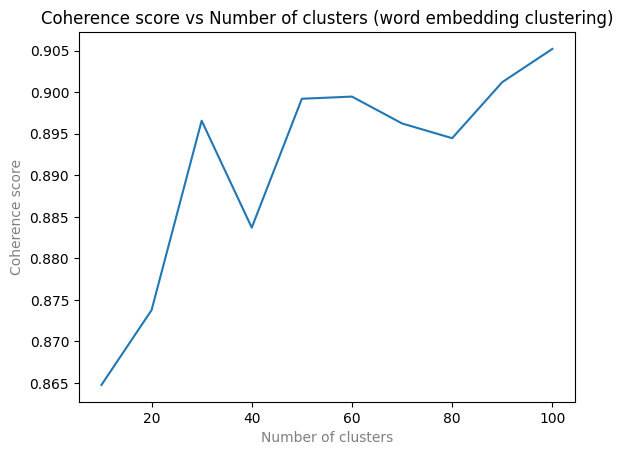

In [ ]:
plt.plot(num_clusters, c_v)
plt.title("Coherence score vs Number of clusters (word embedding clustering)")
plt.xlabel("Number of clusters", color="gray")
plt.ylabel("Coherence score", color="gray")

In [12]:
# top_words_per_cluster = {}
# for cluster in range(num_clusters):
#     cluster_df = df[df['cluster'] == cluster]
#     top_words_per_cluster[cluster] = get_top_words(cluster_df, n=10)

# # Display the most used words in each cluster
# for cluster, words in top_words_per_cluster.items():
#     print(f"Cluster {cluster}: {words}")

In [13]:
# from IPython.display import FileLink
# FileLink('data_w_clusters.csv')

## BERTopic

In [14]:
from bertopic import BERTopic

model = BERTopic(language="multilingual")
topics, probs = model.fit_transform(sentences)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already b

In [ ]:
topic_words = model.get_topic_info()

# Create a dictionary of topics with their words
topics_dict = {}
for topic in range(len(topic_words)):
    words = model.get_topic(topic)
    if not words:
        continue
    topics_dict[topic] = [word for word, _ in words]

texts = [sentence.split() for sentence in sentences]
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate coherence score
coherence_model = CoherenceModel(
    topics=topics_dict.values(),
    texts=texts,
    dictionary=dictionary,
    coherence="c_v",
)
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

Coherence Score: 0.28174091608064394


In [19]:
topics_dict

{0: ['лесу',
  'лес',
  'дерево',
  'дерева',
  'леса',
  'деревья',
  'деревьев',
  'деревьями',
  'лесной',
  'дрова'],
 1: ['ма', 'та', 'ос', 'ла', 'хо', 'ва', 'гыт', 'са', 'па', 'нэ'],
 2: ['рыбу',
  'рыбы',
  'ловить',
  'рыба',
  'рыбой',
  'рыбалку',
  'ловят',
  'рыбачить',
  'рыбаком',
  'рыбаки'],
 3: ['россии',
  'русски',
  'русском',
  'русский',
  'москву',
  'языке',
  'москве',
  'всей',
  'путин',
  'москвы'],
 4: ['деревня',
  'деревню',
  'деревни',
  'город',
  'павыл',
  'деревне',
  'площадь',
  'города',
  'село',
  'поселок'],
 5: ['шить',
  'одежду',
  'платья',
  'платье',
  'бисера',
  'одежды',
  'украшения',
  'шила',
  'мансийские',
  'сукна'],
 6: ['жена',
  'муж',
  'жену',
  'жене',
  'жены',
  'женой',
  'мужа',
  'замуж',
  'мужу',
  'мужем'],
 7: ['собака',
  'собаки',
  'собаку',
  'собак',
  'собачка',
  'лают',
  'лай',
  'собакой',
  'щенка',
  'собаками'],
 8: ['она',
  'её',
  'ей',
  'неё',
  'душу',
  'схватила',
  'подошла',
  'ее',
  'лиса'

In [16]:
from gensim.models import LdaModel

In [ ]:
# Tokenize the sentences
tokenized_sentences = [
    preprocess_and_tokenize(sentence) for sentence in sentences
]

# Remove stopwords
russian_stopwords = set(stopwords.words("russian"))
filtered_sentences = [
    [
        word
        for word in tokens
        if word not in russian_stopwords and len(word) > 3
    ]
    for tokens in tokenized_sentences
]

# Create a dictionary and corpus for LDA
dictionary = gensim.corpora.Dictionary(filtered_sentences)
corpus = [dictionary.doc2bow(text) for text in filtered_sentences]

c_v = []
num_clusters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for n in num_clusters:
    print("Number of clusters: ", n)
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary, passes=15)

    # Print the topics
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=filtered_sentences,
        dictionary=dictionary,
        coherence="c_v",
    )
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"Coherence Score: {coherence_lda}")
    c_v.append(coherence_lda)

Number of clusters:  10
Topic 0: 0.025*"дальше" + 0.015*"очень" + 0.014*"делать" + 0.014*"люди" + 0.014*"других" + 0.014*"работы" + 0.014*"которые" + 0.011*"рассказы" + 0.010*"коренных" + 0.010*"просто"
Topic 1: 0.021*"домой" + 0.020*"россии" + 0.020*"сюда" + 0.017*"постоянно" + 0.016*"затем" + 0.016*"около" + 0.015*"разных" + 0.014*"говорят" + 0.014*"такие" + 0.013*"тысяч"
Topic 2: 0.047*"туда" + 0.025*"мужчина" + 0.023*"язык" + 0.020*"сказала" + 0.019*"деньги" + 0.018*"жить" + 0.017*"сказал" + 0.014*"сразу" + 0.010*"говорит" + 0.010*"дали"
Topic 3: 0.037*"очень" + 0.029*"дома" + 0.020*"среди" + 0.019*"другие" + 0.017*"народ" + 0.016*"работают" + 0.014*"жизни" + 0.014*"нужно" + 0.011*"работающие" + 0.011*"оленей"
Topic 4: 0.039*"человек" + 0.033*"работает" + 0.019*"могут" + 0.018*"школе" + 0.014*"денег" + 0.013*"деревни" + 0.013*"прошлом" + 0.012*"рублей" + 0.012*"стало" + 0.010*"жили"
Topic 5: 0.032*"пусть" + 0.023*"языке" + 0.019*"город" + 0.017*"людям" + 0.014*"также" + 0.012*"собо

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.2986681648013513
Number of clusters:  20
Topic 0: 0.117*"человек" + 0.075*"сказал" + 0.066*"дело" + 0.051*"говорит" + 0.031*"доме" + 0.024*"друг" + 0.023*"народа" + 0.017*"жена" + 0.014*"мальчик" + 0.013*"мясо"
Topic 1: 0.120*"людей" + 0.041*"отец" + 0.036*"деревни" + 0.033*"человека" + 0.030*"исполнилось" + 0.025*"ездили" + 0.022*"почему" + 0.021*"является" + 0.020*"отправили" + 0.016*"большая"
Topic 2: 0.059*"среди" + 0.048*"других" + 0.047*"работы" + 0.032*"места" + 0.029*"стала" + 0.028*"чтото" + 0.027*"людей" + 0.026*"землю" + 0.025*"всей" + 0.024*"земле"
Topic 3: 0.077*"городе" + 0.074*"пусть" + 0.072*"дети" + 0.040*"деньги" + 0.038*"другие" + 0.033*"также" + 0.028*"денег" + 0.026*"работала" + 0.024*"детям" + 0.021*"сделали"
Topic 4: 0.098*"время" + 0.049*"некоторые" + 0.044*"жить" + 0.043*"школе" + 0.041*"сюда" + 0.027*"стало" + 0.026*"учиться" + 0.023*"дали" + 0.021*"летом" + 0.017*"начали"
Topic 5: 0.133*"года" + 0.074*"разные" + 0.029*"стал" + 0.022*"оконча

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.4605818305499113
Number of clusters:  30
Topic 0: 0.236*"году" + 0.053*"делать" + 0.033*"посёлке" + 0.030*"чтото" + 0.027*"говорить" + 0.027*"нашей" + 0.025*"учится" + 0.024*"является" + 0.020*"ольга" + 0.017*"должны"
Topic 1: 0.177*"время" + 0.048*"дочь" + 0.041*"быстро" + 0.034*"всем" + 0.030*"брат" + 0.028*"такую" + 0.028*"сестра" + 0.027*"наших" + 0.018*"приехали" + 0.018*"мужчин"
Topic 2: 0.134*"день" + 0.083*"среди" + 0.079*"людям" + 0.045*"жителей" + 0.043*"месте" + 0.037*"школу" + 0.028*"праздник" + 0.023*"папа" + 0.022*"друг" + 0.019*"плохо"
Topic 3: 0.116*"сказал" + 0.082*"россии" + 0.077*"других" + 0.052*"работающие" + 0.041*"летом" + 0.033*"семья" + 0.029*"хорошие" + 0.027*"изза" + 0.020*"отдыха" + 0.020*"осенью"
Topic 4: 0.052*"сколько" + 0.040*"начал" + 0.031*"правда" + 0.029*"нашего" + 0.027*"ребенка" + 0.026*"руками" + 0.026*"села" + 0.024*"нашу" + 0.024*"девушки" + 0.022*"знать"
Topic 5: 0.064*"около" + 0.054*"долго" + 0.047*"приезжали" + 0.036*"кото

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.5385526415380968
Number of clusters:  40
Topic 0: 0.081*"деревню" + 0.077*"годы" + 0.043*"ребенка" + 0.041*"села" + 0.029*"являются" + 0.025*"семью" + 0.025*"магазине" + 0.019*"подарок" + 0.016*"нарты" + 0.016*"вместо"
Topic 1: 0.188*"человек" + 0.085*"россии" + 0.084*"сюда" + 0.082*"говорит" + 0.030*"сына" + 0.027*"рассказывала" + 0.023*"нашего" + 0.021*"одно" + 0.020*"взяли" + 0.018*"няксимволь"
Topic 2: 0.305*"году" + 0.110*"работу" + 0.052*"лесу" + 0.046*"дочь" + 0.043*"сделали" + 0.040*"быстро" + 0.037*"школу" + 0.026*"столько" + 0.026*"приехал" + 0.017*"мясо"
Topic 3: 0.097*"около" + 0.044*"одежду" + 0.037*"думаю" + 0.035*"организации" + 0.034*"одного" + 0.032*"центре" + 0.026*"красивые" + 0.024*"своем" + 0.024*"деятельности" + 0.023*"найти"
Topic 4: 0.245*"детей" + 0.165*"городе" + 0.062*"своих" + 0.046*"одна" + 0.038*"летом" + 0.037*"нашей" + 0.030*"двух" + 0.026*"большое" + 0.012*"мамы" + 0.012*"купить"
Topic 5: 0.202*"дальше" + 0.067*"дали" + 0.047*"праздни

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.5748533093433423
Number of clusters:  50
Topic 0: 0.239*"человек" + 0.152*"каждый" + 0.106*"сюда" + 0.048*"учится" + 0.037*"маленькие" + 0.032*"сердце" + 0.030*"организации" + 0.029*"нашего" + 0.021*"случае" + 0.020*"песню"
Topic 1: 0.212*"деньги" + 0.082*"многие" + 0.081*"стоит" + 0.041*"продукты" + 0.035*"приходит" + 0.025*"большим" + 0.024*"мальчики" + 0.018*"своему" + 0.015*"тобой" + 0.013*"бересту"
Topic 2: 0.121*"домой" + 0.113*"делать" + 0.069*"посёлке" + 0.051*"ними" + 0.042*"приехал" + 0.038*"новый" + 0.035*"думаю" + 0.030*"нами" + 0.026*"дочери" + 0.021*"петь"
Topic 3: 0.124*"родился" + 0.123*"женщины" + 0.062*"пока" + 0.046*"мальчик" + 0.036*"вниз" + 0.035*"горы" + 0.035*"какую" + 0.028*"написать" + 0.025*"вернулся" + 0.020*"семи"
Topic 4: 0.121*"рублей" + 0.103*"жители" + 0.058*"семь" + 0.055*"рассказывала" + 0.053*"хороших" + 0.046*"сделал" + 0.034*"последние" + 0.029*"ходил" + 0.022*"хорошей" + 0.019*"домах"
Topic 5: 0.110*"жизнь" + 0.084*"земле" + 0.05

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.5718473285110504
Number of clusters:  60
Topic 0: 0.241*"человек" + 0.144*"разные" + 0.109*"россии" + 0.073*"коренных" + 0.069*"жителей" + 0.055*"детьми" + 0.054*"этому" + 0.020*"друга" + 0.016*"нашим" + 0.015*"интернате"
Topic 1: 0.143*"будем" + 0.035*"своему" + 0.035*"вместо" + 0.030*"дала" + 0.027*"лошади" + 0.019*"своё" + 0.019*"сделаем" + 0.014*"научились" + 0.014*"мужу" + 0.010*"сшить"
Topic 2: 0.118*"времени" + 0.099*"семь" + 0.066*"девушки" + 0.057*"таким" + 0.047*"прошло" + 0.023*"голосом" + 0.019*"женщинам" + 0.017*"хорошего" + 0.015*"мясом" + 0.015*"внизу"
Topic 3: 0.126*"свои" + 0.118*"сами" + 0.101*"слова" + 0.067*"многие" + 0.062*"праздник" + 0.059*"сестра" + 0.034*"следующий" + 0.028*"народы" + 0.021*"пришёл" + 0.017*"море"
Topic 4: 0.248*"поэтому" + 0.112*"лесу" + 0.110*"женщины" + 0.101*"жили" + 0.047*"хороших" + 0.044*"начала" + 0.014*"ушли" + 0.013*"любят" + 0.013*"дверь" + 0.009*"красивая"
Topic 5: 0.079*"человеком" + 0.063*"лишь" + 0.057*"песню" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.48842366885811894
Number of clusters:  70
Topic 0: 0.071*"огонь" + 0.048*"дрова" + 0.048*"спать" + 0.024*"поели" + 0.022*"пищу" + 0.010*"легли" + 0.010*"сварили" + 0.006*"горячую" + 0.000*"помногу" + 0.000*"поубивал"
Topic 1: 0.209*"районе" + 0.149*"дочь" + 0.053*"посёлка" + 0.042*"солнце" + 0.041*"мансийская" + 0.031*"осталась" + 0.028*"дому" + 0.022*"берёзовском" + 0.018*"вечер" + 0.012*"начало"
Topic 2: 0.188*"постоянно" + 0.172*"своей" + 0.143*"слова" + 0.069*"жена" + 0.035*"стол" + 0.017*"едой" + 0.012*"ленинграда" + 0.008*"мышонок" + 0.007*"услышал" + 0.004*"пили"
Topic 3: 0.180*"прошлом" + 0.175*"рублей" + 0.167*"стало" + 0.049*"таким" + 0.033*"наше" + 0.020*"голосом" + 0.008*"плачет" + 0.005*"машин" + 0.004*"хозяйство" + 0.004*"помогу"
Topic 4: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 5: 0.557*"детей" + 0.085*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.4419956241845866
Number of clusters:  80
Topic 0: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 1: 0.186*"около" + 0.158*"жили" + 0.094*"сама" + 0.065*"оказывается" + 0.049*"девочка" + 0.033*"живу" + 0.030*"силу" + 0.028*"сердца" + 0.016*"кричит" + 0.015*"кормить"
Topic 2: 0.134*"учиться" + 0.093*"многие" + 0.090*"одну" + 0.086*"праздник" + 0.062*"взял" + 0.039*"женщину" + 0.038*"народы" + 0.037*"хочет" + 0.030*"москвы" + 0.027*"тюмени"
Topic 3: 0.049*"мимо" + 0.033*"сняли" + 0.013*"продали" + 0.004*"египет" + 0.004*"иосифа" + 0.000*"плетенный" + 0.000*"сэмылуймисыаки" + 0.000*"сгибает" + 0.000*"выгыруймисыаки" + 0.000*"гнилым"
Topic 4: 0.128*"двух" + 0.108*"наша" + 0.077*"девушка" + 0.057*"возили" + 0.045*"имеется" + 0.039*"сети" + 0.033*"пошёл" + 0.028*"держали" + 0.022*"лошадей" + 0.013*"радостно"
Topic 5: 0.339*"дети" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.41731738274344254
Number of clusters:  90
Topic 0: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 1: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 2: 0.345*"сказала" + 0.054*"приходят" + 0.052*"мать" + 0.051*"пришла" + 0.040*"берут" + 0.034*"смотрят" + 0.033*"стоят" + 0.025*"дверь" + 0.016*"твои" + 0.011*"менкв"
Topic 3: 0.379*"мужчина" + 0.211*"жизни" + 0.064*"другом" + 0.027*"моим" + 0.011*"будь" + 0.007*"середины" + 0.005*"сделай" + 0.005*"прошу" + 0.003*"дошёл" + 0.002*"пола"
Topic 4: 0.161*"давно" + 0.115*"русский" + 0.066*"болезни" + 0.063*"остался" + 0.057*"времена" + 0.039*"умерли" + 0.024*"женщинам" + 0.019*"мясом" + 0.013*"живых" + 0.009*"северной"
Topic 5: 0.193*"могут

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.4056139563588063
Number of clusters:  100
Topic 0: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 1: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 2: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 3: 0.000*"прохоженную" + 0.000*"жирным" + 0.000*"выгыруймисыаки" + 0.000*"гнилым" + 0.000*"сгибает" + 0.000*"веткой" + 0.000*"плетенный" + 0.000*"ельнике" + 0.000*"осмотри" + 0.000*"рычать"
Topic 4: 0.234*"немного" + 0.206*"этих" + 0.135*"находится" + 0.075*"стороны" + 0.025*"ниже" + 0.018*"сосьвы" + 0.016*"небольшой" + 0.005*"левой" + 0.005*"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.39153284921990583


Text(0, 0.5, 'Coherence score')

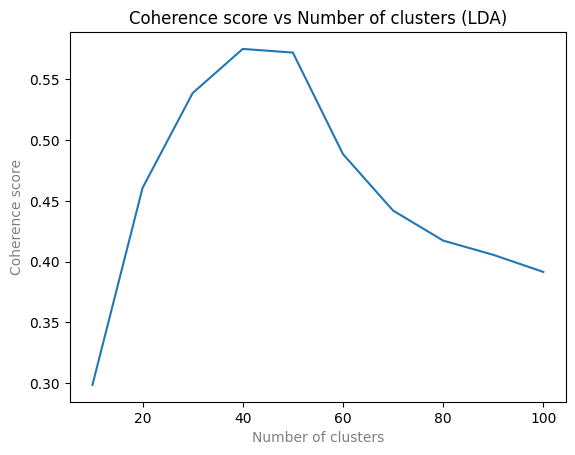

In [ ]:
plt.plot(num_clusters, c_v)
plt.title("Coherence score vs Number of clusters (LDA)")
plt.xlabel("Number of clusters", color="gray")
plt.ylabel("Coherence score", color="gray")